# UrbanSound8k - Capstone Project - Part 1

---

**PROJECT OVERVIEW**
<br><br>
Environmental noise or noise pollution, which is defined as an unwanted or harmful outdoor sound created by human activity [1], is a growing problem in urban area. This noise pollution can affect the quality of life and health. Recent studies [2] have shown that exposure to noise pollution may increase the health risk. Therefore, decreasing the noise in the human environment can contribute to increase both the quality of life and health.
<br><br>
Environmental noise monitoring systems continuously measure the sound levels to quantify the noise level. However, it can be of interest to identify the type of noise source. By combining the noise level and the type of noise in real time we can describe the acoustic environment in a more complete way. Based on the outcome, actions can be taken to reduce the noise levels in urban areas. However, finding the type of noise can be a challenging task there an audio recording contains a mix of different noise sources. Here machine learning can be a helpful tool.
<br><br>
A way to build a real time monitoring system is the use of a low cost, small size, low power, wireless embedded device. Today, there is some attention to perform machine learning direct on these devices, so called machine learning on the edge, where we deploy a pre-trained neural network close to the sensor. However, because a limit memory footprint and compute resources the deployment of a neural network on an embedded device can be a challenge. Because these limitations trade-off needs to be made between memory footprint, compute power and the accuracy of the neural network.
<br><br>
**PROBLEM STATEMENT**
<br><br>
The design of a real time smart embedded monitoring system is, given the limit timeframe of this capstone project, out of the scope. The main objective of this capstone project is to take a first (small) step in the design of real time smart embedded system for environmental sound classification (ESC). In this capstone project we focus on the feature engineering step and the neural network design.
<br><br>
**DATASET**
<br><br>
For the project the [UrbandSound8k](https://urbansounddataset.weebly.com/urbansound8k.html) is selected.
The UrbanSound8k is a dataset that contains 8732 labelled sound excerpts of urban sounds, in WAV format. These excerpts are less or equal to 4s. There are 10 classes defined: air conditioner, car horn, children plying, dog bark, drilling, engine idling, gun shot, jackhammer, siren and street music. The sampling rate, bit depth, and number of channels can vary from file to file. The files are pre-sorted into ten folds for cross validation and saved in folders named fold1 to fold10. 
<br><br>
**REFERENCES**
<br><br>
[1] Directive 2002/49/EC of the European Parliament and of the Council of 25 June 2002 Relating to the Assessment and Management of Environmental Noise, Jun. 2002.
<br><br>
[2] L. Poon, The Sound of Heavy Traffic Might Take a Toll on Mental Health, CityLab. [Online]( https://www.citylab.com/equity/2015/11/city-noise-mental-health-traffic-study/417276/)
<br><br>
[3] J. Salamon, C. Jacoby and J. P. Bello, A dataset and Taxonomy for Urban Sound Research, 22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014. [Paper (pdf)](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf)

---

# PART 1
## DATA PRE-PROCESSING

**If there is preprocessed data available go to Part 2.**

In [1]:
import librosa
import librosa.display

from collections import Counter

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Example: audio clip and the Mel spectrum

In [2]:
# Get meta
PATH_META_DATA = "./dataset/metadata/UrbanSound8K.csv"

meta_data = pd.read_csv(PATH_META_DATA)
print('Number of wav files:', meta_data.shape[0])
meta_data.head()

Number of wav files: 8732


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [3]:
meta_data = meta_data.sample(frac=1)
meta_data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
6437,42953-9-0-21.wav,42953,10.500000,14.500000,1,9,9,street_music
8359,89442-9-0-6.wav,89442,3.000000,7.000000,1,6,9,street_music
6137,34056-2-0-40.wav,34056,20.000000,24.000000,2,4,2,children_playing
5841,24347-8-0-89.wav,24347,48.620371,52.620371,2,4,8,siren
7749,74507-0-0-1.wav,74507,0.500000,4.500000,1,2,0,air_conditioner


In [4]:
AUDIO_PATH = "./dataset/audio/fold2/100652-3-0-0.wav"

Sampling rate: 16000


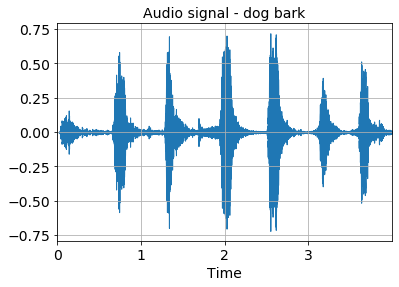

In [5]:
audio_signal, fs = librosa.load(AUDIO_PATH, mono=True, sr=16000)
librosa.display.waveplot(audio_signal, sr=fs)
print('Sampling rate:', fs)
    
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title('Audio signal - dog bark', fontsize=14)
plt.ylabel("", fontsize=10);plt.xlabel("Time", fontsize=14);
plt.grid()

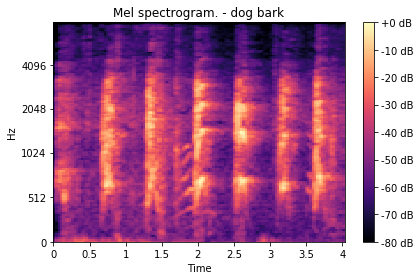

In [6]:
S = librosa.feature.melspectrogram(y=audio_signal, sr=fs, n_mels=128, fmax=fs/2)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=fs, y_axis='mel', fmax=fs/2, x_axis='time')
plt.title('Mel spectrogram. - dog bark')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

### FEATURE ENGINEERING

The audio clips are resampled to a sample rate of 16kHz, and a mono channel is used. In the capstone project no data augmentation is performed. Given the audio clips are less or equal to 4s and the CNN request a fixed length segment the audio clips will be divided into equal length frames using a similar approach as described in [Paper (pdf)](https://www.karolpiczak.com/papers/Piczak2015-ESC-ConvNet.pdf) and [Urban Sound Classification Part 2:
Applying Convolutional Neural Network](http://aqibsaeed.github.io/2016-09-24-urban-sound-classification-part-2/). The fixed segments are converted to the [Mel spectrogram](https://librosa.github.io/librosa/generated/librosa.feature.melspectrogram.html) which is used as feature input for the neural network.

In [7]:
def extract_features(path, filename_list, sample_rate, n_mels):
    """
    Args:
        path: path to the audio files
        filename_list: list of audio files
        sample_rate: target sampling rate
        n_mels: number of Mel bands to generate
    
    Returns:
        specgrams_array: array of melspectrogram in dB 
        labels: labels
    
    """
    clip_lenght = 4
    
    specgrams = []
    labels = []
    
    for file in filename_list:
        sound_clip, sr = librosa.load(path+file, sr=sample_rate)
        # add zero to the audioclip so the total lenght becomes 4 sec
        
        if len(sound_clip) < clip_lenght*sr:
            sound_clip = np.pad(sound_clip, (0, clip_lenght*sr-len(sound_clip)), 'constant')
        
        signal = sound_clip[0:clip_lenght*sample_rate]
        S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=sr/2)
        S_dB = librosa.power_to_db(S, ref=np.max)
    
        specgrams.append(S_dB)
        
        labels.append(file.split('-')[1]) 
            
    specgrams_array = np.asarray(specgrams).reshape(len(specgrams),specgrams[0].shape[0],specgrams[0].shape[1])
    
    return specgrams_array, labels

In [8]:
# Parameters
sample_rate = 16000
n_mels = 128

In [9]:
# extract feature of the audio clip and save

for fold_nmb in range(1,11):
    print('fold:', fold_nmb)
    filename_list = list(meta_data.loc[meta_data['fold'] == fold_nmb]['slice_file_name'])
    path = "./dataset/audio/fold"+str(fold_nmb)+"/"
    
    melspectrogram, labels = extract_features(path, filename_list, sample_rate, n_mels)
    
    np.save("./dataset/audio/fold/melspectrogram_fold"+str(fold_nmb), melspectrogram)
    np.save("./dataset/audio/fold/labels_fold"+str(fold_nmb), labels)

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10


---

# PART 2

## Read data from disk

In [10]:
import librosa
import librosa.display

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
melspectrogram = []
labels = []

for i in range(1,11):
    melspectrogram.append(np.load("./dataset/audio/fold/melspectrogram_fold"+str(i)+".npy"))
    labels.append(np.load("./dataset/audio/fold/labels_fold"+str(i)+".npy"))

---

# PART 3

## Train dataset

In [12]:
fold_training = [4, 5, 6, 7, 8, 9, 10]
fold_validation = [2, 3]
fold_test = [1]

In [15]:
melspectrogram_train = (melspectrogram[fold_training[0]-1], melspectrogram[fold_training[1]-1], 
                  melspectrogram[fold_training[2]-1], melspectrogram[fold_training[3]-1], 
                  melspectrogram[fold_training[4]-1], melspectrogram[fold_training[5]-1], 
                  melspectrogram[fold_training[6]-1])
labels_train = (labels[fold_training[0]-1], labels[fold_training[1]-1], labels[fold_training[2]-1],
          labels[fold_training[3]-1], labels[fold_training[4]-1], labels[fold_training[5]-1],
          labels[fold_training[6]-1])

melspectrogram_validation = (melspectrogram[fold_validation[0]-1], melspectrogram[fold_validation[1]-1])
labels_validation = (labels[fold_validation[0]-1], labels[fold_validation[1]-1])
                        
melspectrogram_train = np.concatenate(melspectrogram_train, axis=0)
labels_train = np.concatenate(labels_train, axis=0)

melspectrogram_validation = np.concatenate(melspectrogram_validation, axis=0)
labels_validation = np.concatenate(labels_validation, axis=0)

## Standardize features

In [16]:
mean = np.mean(melspectrogram_train, axis = 0)
std = np.std(melspectrogram_train, axis = 0)

X_train_stand_score = (melspectrogram_train-mean)/std
X_val_stand_score = (melspectrogram_validation-mean)/std 
X_test_stand_score = (melspectrogram[fold_test[0]-1]-mean)/std

## Neural Network

### Convolution Neural Network

In [17]:
import keras
print(keras.__version__)

from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

from keras.regularizers import l1
from keras.regularizers import l2

from keras.utils import to_categorical

from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import LeakyReLU

from keras.models import Sequential

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import itertools

Using TensorFlow backend.


2.2.4


In [18]:
# ref.: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [19]:
def network(model, epochs, batch_size, lr):
    
    opt = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(X_val, y_val))
    
    history_dict = history.history
 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    print('')
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'bx-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    plt.clf()   # clear figure
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    plt.plot(epochs, acc, 'bo-', label='Training acc')
    plt.plot(epochs, val_acc, 'bx-', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()
    
    print('')
    print('Test accurancy:')
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print('', 100*test_acc, '%')
    
    print('')
    y_pred = model.predict(X_test)

    classID = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    classes = ['air conditioner', 'car horn', 'children playing', 'dog bark', 
           'drilling','engine idling', 'gun shot', 'jackhammer', 'siren', 'street music']

    matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classID)
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    plt.figure(figsize=(8, 8))
    plot_confusion_matrix(matrix, classes=classes, normalize=True, title='Normalized confusion matrix')
    print("Test accuracy = " + str(100*accuracy))

**Preparing the train, test and validation data**

In [20]:
X_train = X_train_stand_score.reshape((X_train_stand_score.shape[0], X_train_stand_score.shape[1], X_train_stand_score.shape[2], 1))
X_test = X_test_stand_score.reshape((X_test_stand_score.shape[0], X_test_stand_score.shape[1], X_test_stand_score.shape[2], 1))
X_val = X_val_stand_score.reshape((X_val_stand_score.shape[0], X_val_stand_score.shape[1], X_val_stand_score.shape[2], 1))

**Preparing the labels**

In [21]:
y_train = to_categorical(labels_train)
y_val = to_categorical(labels_validation)
y_test = to_categorical(labels[fold_test[0]-1])

**CNN**

W1103 10:20:51.281401  7852 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1103 10:20:51.281401  7852 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1103 10:20:51.336202  7852 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1103 10:20:51.340202  7852 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1103 10:20:51.344202  7852 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 124, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 122, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 124, 122, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 484096)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 125)               60512125  
_________________________________________________________________
activation_3 (Activation)    (None, 125)               0         
__________

Epoch 48/50
6046/6046 [==============================] - 8s 1ms/step - loss: 1.8877e-05 - acc: 1.0000 - val_loss: 3.6391 - val_acc: 0.5383
Epoch 49/50
6046/6046 [==============================] - 8s 1ms/step - loss: 1.8052e-05 - acc: 1.0000 - val_loss: 3.6309 - val_acc: 0.5389
Epoch 50/50
6046/6046 [==============================] - 8s 1ms/step - loss: 1.7153e-05 - acc: 1.0000 - val_loss: 3.6443 - val_acc: 0.5389



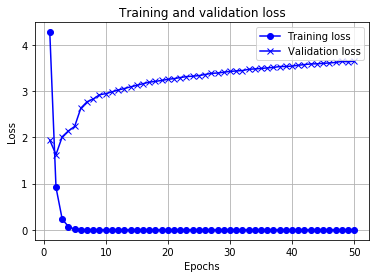

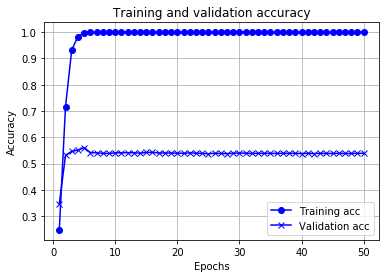


Test accurancy:
873/873 [==============================] - 1s 650us/step
 59.908361997527905 %

Normalized confusion matrix
[[0.32 0.04 0.16 0.   0.01 0.06 0.   0.14 0.25 0.02]
 [0.   0.83 0.   0.06 0.   0.   0.11 0.   0.   0.  ]
 [0.01 0.01 0.84 0.07 0.   0.02 0.   0.   0.01 0.04]
 [0.01 0.04 0.12 0.73 0.   0.03 0.01 0.01 0.   0.05]
 [0.1  0.02 0.08 0.01 0.51 0.01 0.02 0.23 0.01 0.01]
 [0.04 0.   0.02 0.   0.31 0.58 0.   0.   0.03 0.01]
 [0.   0.   0.   0.09 0.09 0.   0.83 0.   0.   0.  ]
 [0.02 0.   0.02 0.02 0.46 0.03 0.   0.28 0.17 0.02]
 [0.05 0.   0.19 0.   0.01 0.   0.   0.   0.7  0.06]
 [0.01 0.03 0.08 0.   0.01 0.02 0.   0.04 0.06 0.75]]
Test accuracy = 59.90836197021764


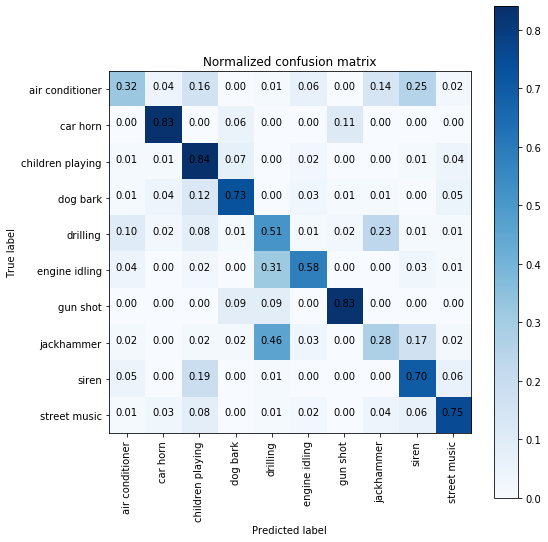

In [22]:
filename_model = 'Baseline_CNN'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10

keras.backend.clear_session()

baseline_model = models.Sequential()
baseline_model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels)))
baseline_model.add(Activation('relu'))
baseline_model.add(Conv2D(32, (3,3)))
baseline_model.add(Activation('relu'))
baseline_model.add(Flatten())
baseline_model.add(Dense(125))
baseline_model.add(Activation('relu'))
baseline_model.add(Dense(125))
baseline_model.add(Activation('relu'))
baseline_model.add(Dense(10,activation ='softmax'))

baseline_model.summary()

network(baseline_model, 50, 125, 0.001)
baseline_model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
__________

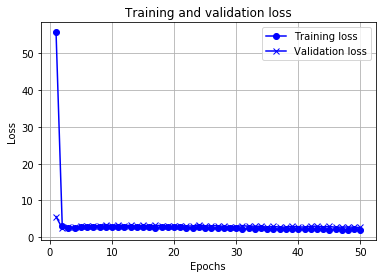

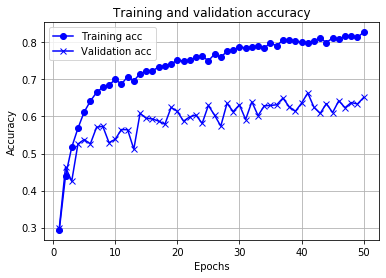


Test accurancy:
873/873 [==============================] - 1s 631us/step
 60.48109966659874 %

Normalized confusion matrix
[[0.06 0.   0.08 0.   0.1  0.2  0.   0.49 0.07 0.  ]
 [0.   0.83 0.   0.   0.   0.   0.14 0.   0.03 0.  ]
 [0.02 0.01 0.83 0.03 0.   0.01 0.   0.   0.02 0.08]
 [0.   0.01 0.19 0.73 0.   0.02 0.01 0.   0.04 0.  ]
 [0.07 0.06 0.04 0.   0.49 0.07 0.04 0.17 0.03 0.03]
 [0.   0.04 0.01 0.   0.02 0.65 0.   0.02 0.   0.26]
 [0.   0.   0.   0.03 0.06 0.   0.91 0.   0.   0.  ]
 [0.   0.   0.   0.01 0.4  0.09 0.   0.44 0.06 0.  ]
 [0.09 0.   0.13 0.   0.   0.03 0.   0.   0.74 0.  ]
 [0.03 0.03 0.05 0.   0.02 0.01 0.   0.03 0.07 0.76]]
Test accuracy = 60.48109965635739


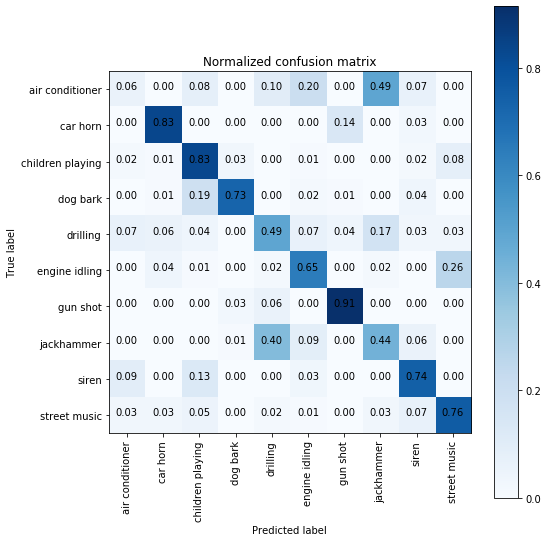

In [25]:
filename_model = 'CNN1'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))        

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 124, 32)      3104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 62, 32)        6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 62, 32)        6176      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
__________

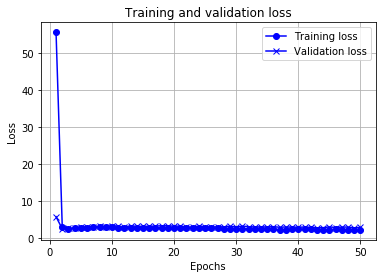

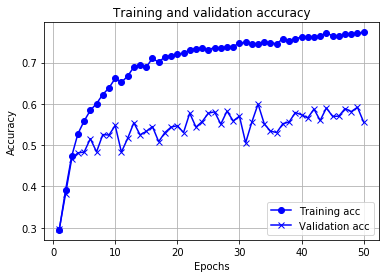


Test accurancy:
873/873 [==============================] - 1s 715us/step
 56.81557849237326 %

Normalized confusion matrix
[[0.33 0.   0.14 0.   0.02 0.14 0.   0.02 0.03 0.32]
 [0.   0.83 0.   0.06 0.   0.   0.11 0.   0.   0.  ]
 [0.01 0.   0.86 0.03 0.01 0.05 0.   0.   0.03 0.01]
 [0.   0.04 0.21 0.69 0.   0.01 0.   0.   0.05 0.  ]
 [0.11 0.09 0.14 0.07 0.28 0.04 0.   0.11 0.06 0.1 ]
 [0.07 0.   0.01 0.   0.   0.59 0.   0.   0.   0.32]
 [0.   0.   0.   0.03 0.11 0.   0.83 0.03 0.   0.  ]
 [0.01 0.   0.15 0.   0.31 0.12 0.   0.38 0.03 0.01]
 [0.   0.   0.29 0.02 0.   0.02 0.   0.   0.66 0.  ]
 [0.05 0.01 0.23 0.   0.01 0.   0.   0.01 0.08 0.61]]
Test accuracy = 56.815578465063


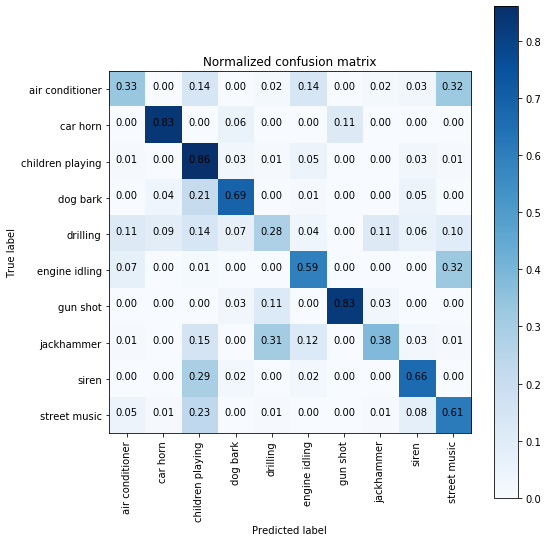

In [27]:
filename_model = 'CNN2'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(MaxPooling2D((1,2), strides=2))
model.add(Activation('relu'))

model.add(Conv2D(32, (6,1), padding='same'))
model.add(Conv2D(32, (6,1), padding='same'))
model.add(MaxPooling2D((4,1), strides=2))
model.add(Activation('relu'))        

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 124, 32)      3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 62, 32)        6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 62, 32)        6176      
__________

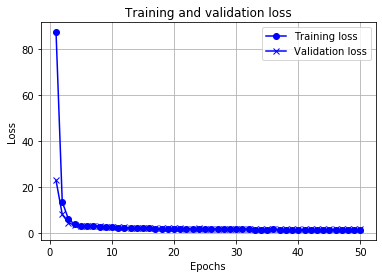

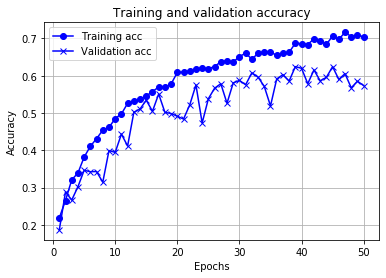


Test accurancy:
873/873 [==============================] - 1s 745us/step
 62.54295532987426 %

Normalized confusion matrix
[[0.49 0.   0.25 0.   0.01 0.18 0.   0.03 0.   0.04]
 [0.   0.58 0.   0.   0.   0.   0.14 0.   0.03 0.25]
 [0.   0.   0.83 0.05 0.01 0.02 0.   0.   0.06 0.03]
 [0.   0.   0.16 0.74 0.01 0.05 0.   0.   0.03 0.01]
 [0.11 0.01 0.02 0.08 0.34 0.04 0.03 0.36 0.01 0.  ]
 [0.02 0.   0.   0.27 0.05 0.66 0.   0.   0.   0.  ]
 [0.   0.   0.   0.2  0.   0.   0.77 0.03 0.   0.  ]
 [0.11 0.   0.05 0.   0.16 0.14 0.   0.49 0.05 0.  ]
 [0.   0.   0.14 0.   0.   0.07 0.   0.   0.79 0.  ]
 [0.11 0.   0.12 0.01 0.01 0.   0.   0.01 0.06 0.68]]
Test accuracy = 62.54295532646048


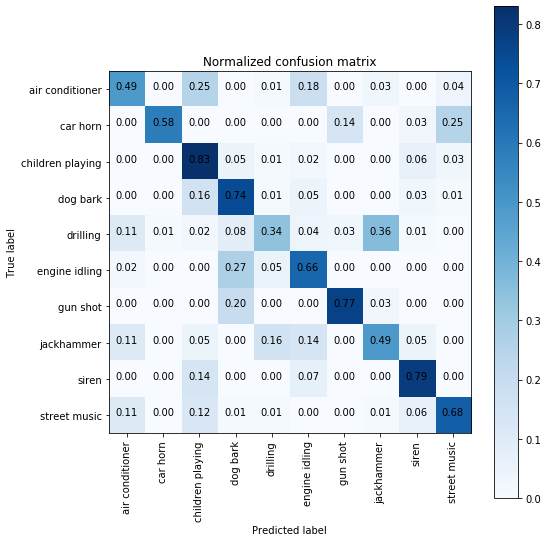

In [28]:
filename_model = 'CNN3'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((1,2), strides=2))
model.add(Activation('relu'))

model.add(Conv2D(32, (6,1), padding='same'))
model.add(Conv2D(32, (6,1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,1), strides=2))
model.add(Activation('relu'))        

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 124, 32)      3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 62, 32)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 62, 32)        6176      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 62, 32)        6176      
__________

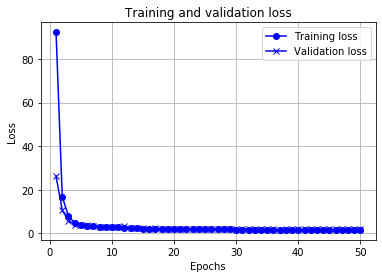

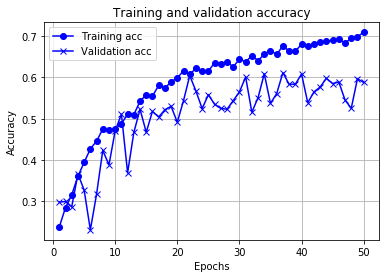


Test accurancy:
873/873 [==============================] - 1s 767us/step
 62.199312735259326 %

Normalized confusion matrix
[[0.5  0.   0.06 0.   0.03 0.1  0.   0.01 0.   0.3 ]
 [0.   0.81 0.   0.03 0.   0.   0.17 0.   0.   0.  ]
 [0.01 0.   0.69 0.04 0.01 0.   0.   0.   0.02 0.23]
 [0.   0.02 0.15 0.7  0.   0.04 0.04 0.   0.02 0.03]
 [0.06 0.09 0.01 0.03 0.62 0.01 0.03 0.12 0.   0.03]
 [0.03 0.   0.02 0.   0.28 0.62 0.   0.   0.   0.04]
 [0.   0.   0.   0.   0.   0.   0.97 0.03 0.   0.  ]
 [0.12 0.01 0.12 0.   0.39 0.05 0.   0.22 0.05 0.04]
 [0.01 0.   0.21 0.   0.   0.03 0.   0.   0.74 0.  ]
 [0.06 0.03 0.03 0.   0.02 0.   0.   0.01 0.06 0.79]]
Test accuracy = 62.19931271477663


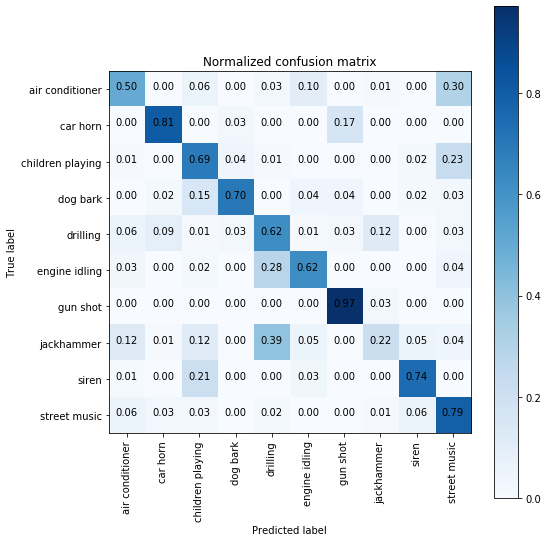

In [29]:
filename_model = 'CNN4'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((1,2), strides=2))
model.add(LeakyReLU(alpha=0.01))

model.add(Conv2D(32, (6,1), padding='same'))
model.add(Conv2D(32, (6,1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((4,1), strides=2))
model.add(LeakyReLU(alpha=0.01))    

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

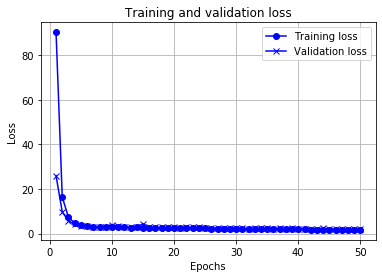

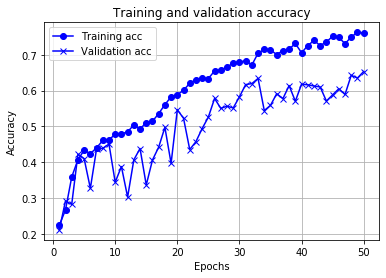


Test accurancy:
873/873 [==============================] - 1s 707us/step
 64.60481101704627 %

Normalized confusion matrix
[[0.3  0.   0.41 0.05 0.01 0.   0.   0.16 0.   0.07]
 [0.   0.83 0.   0.   0.   0.   0.14 0.   0.   0.03]
 [0.02 0.   0.72 0.06 0.   0.   0.   0.   0.   0.2 ]
 [0.   0.   0.11 0.8  0.02 0.   0.02 0.   0.01 0.04]
 [0.08 0.01 0.01 0.   0.73 0.   0.02 0.13 0.   0.02]
 [0.27 0.   0.01 0.   0.32 0.29 0.   0.   0.   0.1 ]
 [0.   0.   0.   0.03 0.11 0.   0.86 0.   0.   0.  ]
 [0.03 0.   0.   0.   0.17 0.02 0.   0.78 0.01 0.  ]
 [0.01 0.   0.33 0.03 0.   0.1  0.   0.   0.52 0.  ]
 [0.06 0.03 0.01 0.   0.06 0.   0.   0.02 0.   0.82]]
Test accuracy = 64.60481099656357


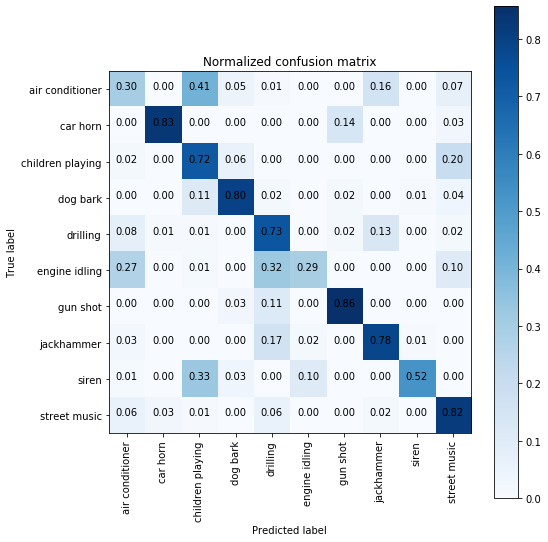

In [30]:
filename_model = 'CNN5'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

Epoch 41/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.8370 - acc: 0.7468 - val_loss: 2.1039 - val_acc: 0.6387
Epoch 42/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.8331 - acc: 0.7532 - val_loss: 2.6000 - val_acc: 0.5494
Epoch 43/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.8164 - acc: 0.7496 - val_loss: 2.3719 - val_acc: 0.5560
Epoch 44/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.7725 - acc: 0.7653 - val_loss: 2.3667 - val_acc: 0.5510
Epoch 45/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.7614 - acc: 0.7623 - val_loss: 2.2161 - val_acc: 0.5946
Epoch 46/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.7775 - acc: 0.7602 - val_loss: 2.2994 - val_acc: 0.6062
Epoch 47/50
6046/6046 [==============================] - 9s 2ms/step - loss: 1.7413 - acc: 0.7638 - val_loss: 2.1290 - val_acc: 0.6492
Epoch 48/50
6046/6046 [==============================] 

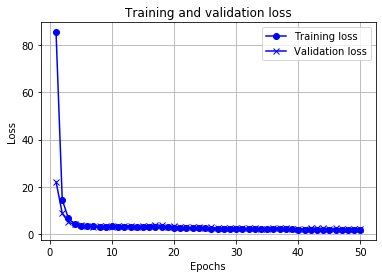

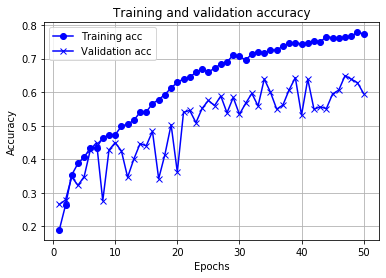


Test accurancy:
873/873 [==============================] - 1s 730us/step
 62.77205042822664 %

Normalized confusion matrix
[[0.01 0.   0.11 0.1  0.01 0.73 0.   0.04 0.   0.  ]
 [0.   0.78 0.   0.03 0.03 0.   0.17 0.   0.   0.  ]
 [0.   0.   0.89 0.08 0.   0.03 0.   0.   0.   0.  ]
 [0.   0.   0.03 0.9  0.   0.04 0.01 0.   0.02 0.  ]
 [0.01 0.   0.04 0.06 0.4  0.08 0.02 0.36 0.02 0.01]
 [0.   0.   0.   0.   0.27 0.68 0.   0.   0.05 0.  ]
 [0.   0.   0.   0.09 0.   0.   0.89 0.03 0.   0.  ]
 [0.   0.   0.   0.   0.   0.29 0.   0.71 0.   0.  ]
 [0.   0.   0.07 0.01 0.   0.12 0.   0.   0.8  0.  ]
 [0.01 0.   0.2  0.02 0.09 0.08 0.   0.04 0.06 0.5 ]]
Test accuracy = 62.77205040091638


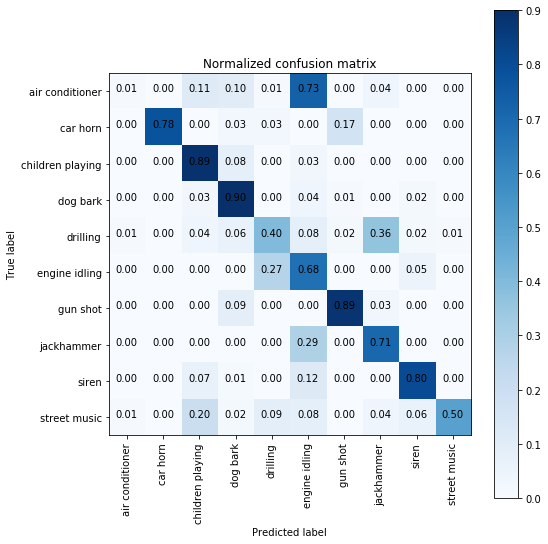

In [31]:
filename_model = 'CNN6'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(LeakyReLU(alpha=0.01)) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(LeakyReLU(alpha=0.01))      

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

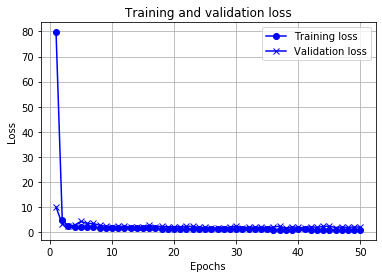

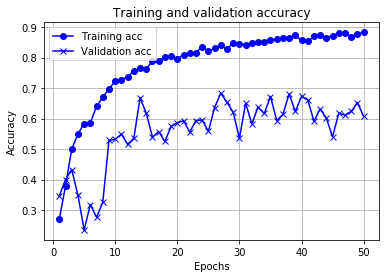


Test accurancy:
873/873 [==============================] - 1s 677us/step
 62.77205042139907 %

Normalized confusion matrix
[[0.2  0.02 0.23 0.09 0.01 0.17 0.   0.08 0.   0.2 ]
 [0.   0.81 0.03 0.   0.   0.   0.17 0.   0.   0.  ]
 [0.   0.   0.95 0.   0.   0.   0.   0.   0.   0.05]
 [0.   0.   0.18 0.79 0.   0.   0.03 0.   0.   0.  ]
 [0.1  0.1  0.08 0.08 0.42 0.01 0.02 0.09 0.04 0.06]
 [0.01 0.   0.18 0.   0.32 0.48 0.01 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.02 0.03 0.   0.   0.38 0.11 0.   0.47 0.   0.  ]
 [0.   0.   0.19 0.01 0.   0.   0.   0.   0.8  0.  ]
 [0.02 0.01 0.16 0.   0.   0.   0.   0.03 0.01 0.77]]
Test accuracy = 62.77205040091638


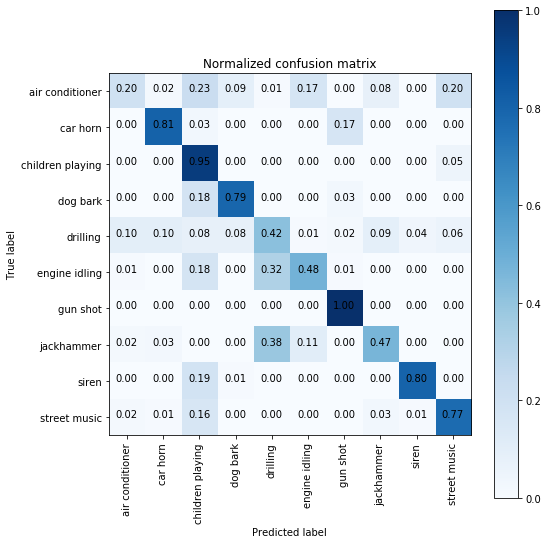

In [32]:
filename_model = 'CNN7'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))       

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 124, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

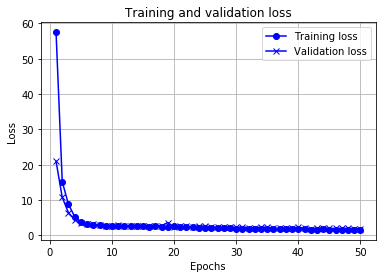

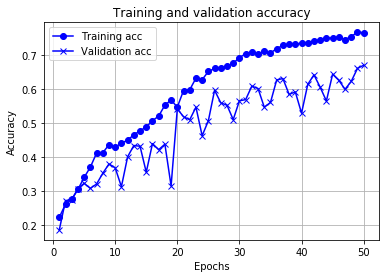


Test accurancy:
873/873 [==============================] - 1s 729us/step
 63.00114547878606 %

Normalized confusion matrix
[[0.33 0.05 0.48 0.   0.02 0.04 0.01 0.07 0.   0.  ]
 [0.   0.75 0.   0.   0.   0.   0.14 0.   0.08 0.03]
 [0.   0.   0.92 0.   0.   0.01 0.   0.   0.05 0.02]
 [0.   0.   0.23 0.67 0.01 0.01 0.03 0.   0.05 0.  ]
 [0.1  0.02 0.06 0.1  0.41 0.   0.02 0.29 0.   0.  ]
 [0.   0.   0.01 0.07 0.25 0.56 0.   0.   0.1  0.  ]
 [0.   0.   0.   0.03 0.03 0.03 0.89 0.03 0.   0.  ]
 [0.   0.   0.   0.01 0.32 0.11 0.   0.56 0.01 0.  ]
 [0.   0.   0.12 0.   0.   0.07 0.   0.   0.81 0.  ]
 [0.05 0.03 0.14 0.   0.   0.   0.   0.04 0.06 0.68]]
Test accuracy = 63.001145475372276


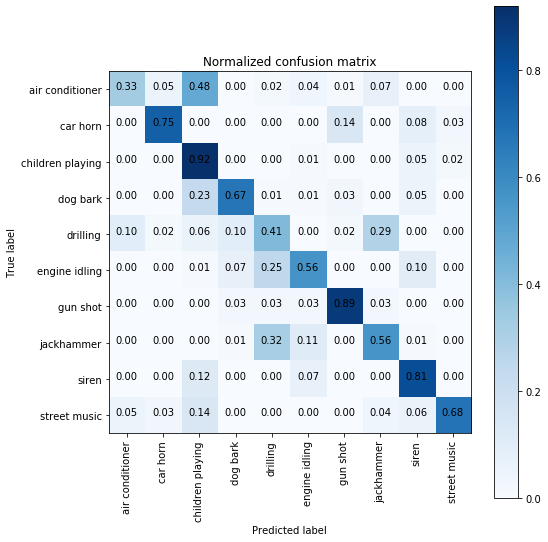

In [33]:
filename_model = 'CNN8'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2), strides=2))
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(512,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(512, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

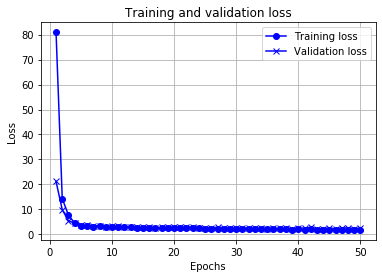

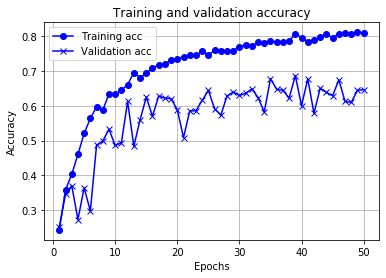


Test accurancy:
873/873 [==============================] - 1s 666us/step
 70.33218787161618 %

Normalized confusion matrix
[[0.52 0.   0.17 0.19 0.03 0.   0.01 0.01 0.   0.07]
 [0.   0.81 0.   0.   0.03 0.   0.17 0.   0.   0.  ]
 [0.   0.   0.95 0.04 0.   0.   0.   0.   0.   0.01]
 [0.   0.   0.06 0.89 0.   0.01 0.03 0.   0.01 0.  ]
 [0.1  0.   0.1  0.12 0.5  0.   0.03 0.13 0.   0.02]
 [0.   0.   0.07 0.05 0.28 0.59 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.03 0.   0.   0.01 0.33 0.   0.   0.62 0.   0.  ]
 [0.03 0.   0.26 0.01 0.   0.   0.   0.   0.7  0.  ]
 [0.05 0.   0.12 0.   0.05 0.   0.   0.03 0.03 0.72]]
Test accuracy = 70.33218785796106


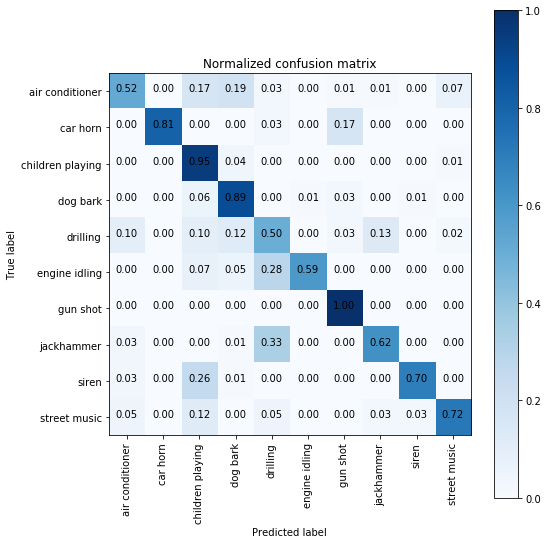

In [34]:
filename_model = 'CNN9'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

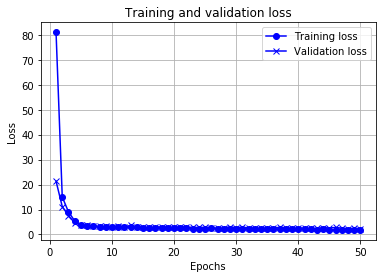

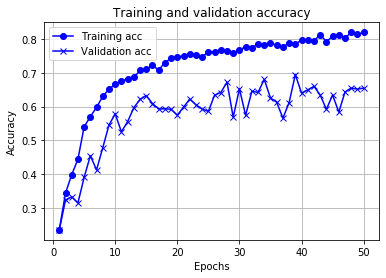


Test accurancy:
873/873 [==============================] - 1s 705us/step
 63.573883188822286 %

Normalized confusion matrix
[[0.26 0.   0.1  0.   0.   0.63 0.   0.01 0.   0.  ]
 [0.   0.78 0.   0.03 0.03 0.   0.14 0.   0.03 0.  ]
 [0.01 0.   0.94 0.   0.   0.03 0.   0.   0.01 0.01]
 [0.03 0.   0.17 0.71 0.   0.06 0.01 0.   0.01 0.01]
 [0.13 0.01 0.03 0.   0.54 0.07 0.03 0.16 0.02 0.01]
 [0.   0.   0.   0.   0.32 0.68 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.3  0.43 0.   0.27 0.   0.  ]
 [0.02 0.   0.07 0.   0.   0.08 0.   0.   0.83 0.  ]
 [0.09 0.01 0.06 0.   0.01 0.01 0.   0.03 0.   0.79]]
Test accuracy = 63.57388316151202


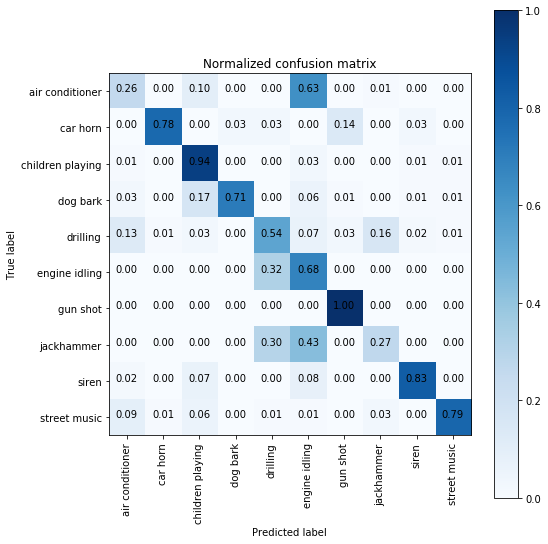

In [35]:
filename_model = 'CNN10'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01)) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.01))      

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 32)        128       
__________

Epoch 35/50
6046/6046 [==============================] - 5s 813us/step - loss: 0.6626 - acc: 0.9439 - val_loss: 1.9151 - val_acc: 0.6851
Epoch 36/50
6046/6046 [==============================] - 5s 789us/step - loss: 0.6244 - acc: 0.9494 - val_loss: 2.0054 - val_acc: 0.6398
Epoch 37/50
6046/6046 [==============================] - 5s 793us/step - loss: 0.6281 - acc: 0.9507 - val_loss: 1.6067 - val_acc: 0.6735
Epoch 38/50
6046/6046 [==============================] - 5s 799us/step - loss: 0.7121 - acc: 0.9421 - val_loss: 2.1576 - val_acc: 0.5913
Epoch 39/50
6046/6046 [==============================] - 5s 821us/step - loss: 0.7122 - acc: 0.9428 - val_loss: 1.6995 - val_acc: 0.6801
Epoch 40/50
6046/6046 [==============================] - 5s 816us/step - loss: 0.5954 - acc: 0.9547 - val_loss: 2.2627 - val_acc: 0.6045
Epoch 41/50
6046/6046 [==============================] - 5s 821us/step - loss: 0.6194 - acc: 0.9507 - val_loss: 3.5286 - val_acc: 0.5405
Epoch 42/50
6046/6046 [==================

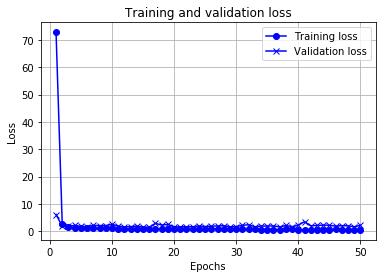

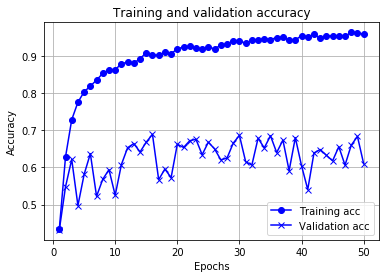


Test accurancy:
873/873 [==============================] - 0s 452us/step
 59.908361997527905 %

Normalized confusion matrix
[[0.37 0.08 0.21 0.21 0.   0.   0.   0.   0.02 0.11]
 [0.   0.86 0.   0.   0.   0.   0.14 0.   0.   0.  ]
 [0.02 0.02 0.86 0.06 0.   0.   0.   0.   0.   0.04]
 [0.   0.   0.07 0.88 0.   0.03 0.01 0.   0.   0.01]
 [0.15 0.21 0.03 0.2  0.28 0.   0.02 0.05 0.   0.06]
 [0.04 0.01 0.   0.23 0.04 0.64 0.   0.   0.04 0.  ]
 [0.   0.   0.   0.03 0.   0.   0.97 0.   0.   0.  ]
 [0.17 0.05 0.02 0.01 0.53 0.11 0.   0.07 0.03 0.01]
 [0.   0.   0.15 0.08 0.   0.   0.   0.   0.77 0.  ]
 [0.01 0.1  0.02 0.01 0.   0.   0.   0.03 0.   0.83]]
Test accuracy = 59.90836197021764


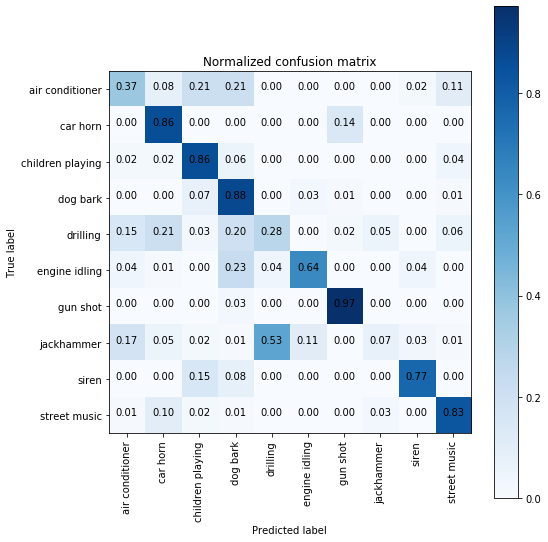

In [36]:
filename_model = 'CNN11'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))   

model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))      

model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))     

model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))    

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(LeakyReLU(alpha=0.01)) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 124, 32)      3104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 62, 32)        7200      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 62, 32)        7200      
__________

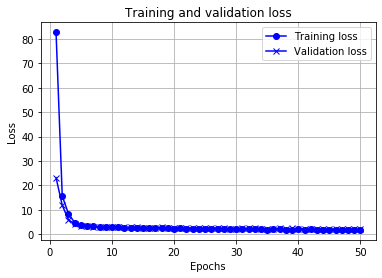

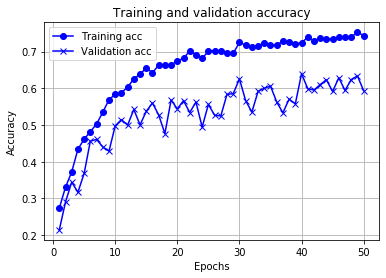


Test accurancy:
873/873 [==============================] - 1s 728us/step
 67.12485683606117 %

Normalized confusion matrix
[[0.58 0.   0.04 0.01 0.11 0.12 0.02 0.01 0.   0.11]
 [0.   0.78 0.   0.03 0.   0.   0.19 0.   0.   0.  ]
 [0.01 0.   0.67 0.12 0.01 0.01 0.   0.   0.03 0.15]
 [0.   0.   0.11 0.79 0.02 0.03 0.01 0.   0.02 0.02]
 [0.16 0.01 0.   0.03 0.52 0.02 0.05 0.2  0.01 0.  ]
 [0.03 0.   0.02 0.04 0.29 0.57 0.   0.   0.   0.04]
 [0.   0.   0.   0.06 0.   0.   0.94 0.   0.   0.  ]
 [0.12 0.   0.01 0.02 0.19 0.04 0.   0.57 0.05 0.  ]
 [0.01 0.   0.16 0.01 0.   0.01 0.   0.   0.8  0.  ]
 [0.12 0.   0.03 0.01 0.01 0.   0.   0.01 0.06 0.76]]
Test accuracy = 67.12485681557845


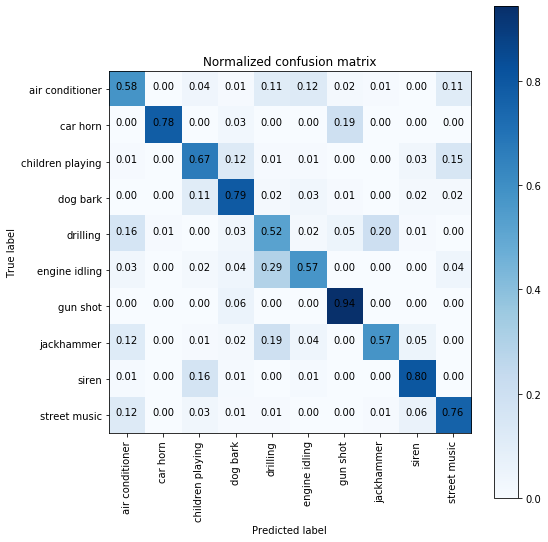

In [37]:
filename_model = 'CNN12'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(MaxPooling2D((1,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (7,1), padding='same'))
model.add(Conv2D(32, (7,1), padding='same'))
model.add(MaxPooling2D((4,1), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

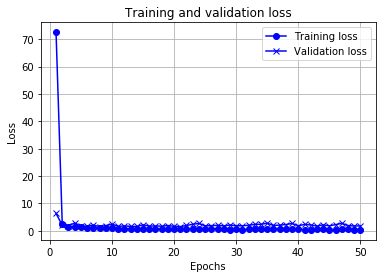

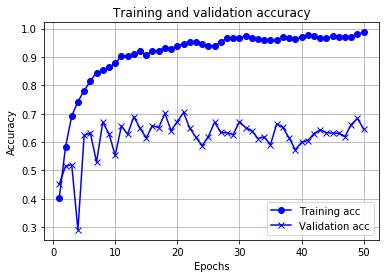


Test accurancy:
873/873 [==============================] - 1s 635us/step
 69.75945019913156 %

Normalized confusion matrix
[[0.38 0.   0.11 0.12 0.03 0.24 0.04 0.05 0.03 0.  ]
 [0.   0.83 0.   0.06 0.   0.   0.11 0.   0.   0.  ]
 [0.01 0.   0.95 0.04 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.06 0.93 0.   0.01 0.   0.   0.   0.  ]
 [0.05 0.   0.13 0.05 0.53 0.01 0.04 0.15 0.   0.04]
 [0.01 0.   0.01 0.32 0.   0.64 0.   0.   0.02 0.  ]
 [0.   0.   0.03 0.09 0.   0.   0.89 0.   0.   0.  ]
 [0.03 0.   0.   0.   0.41 0.   0.03 0.53 0.   0.  ]
 [0.03 0.   0.16 0.02 0.   0.   0.   0.   0.78 0.  ]
 [0.   0.   0.17 0.   0.   0.   0.   0.03 0.03 0.77]]
Test accuracy = 69.7594501718213


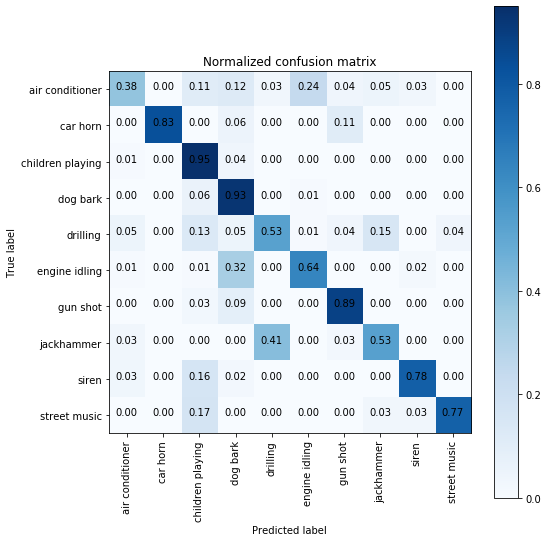

In [38]:
filename_model = 'CNN13'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

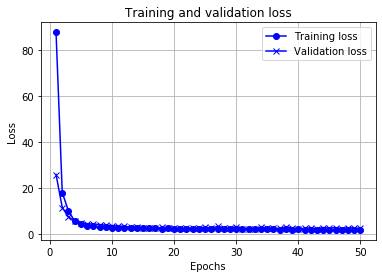

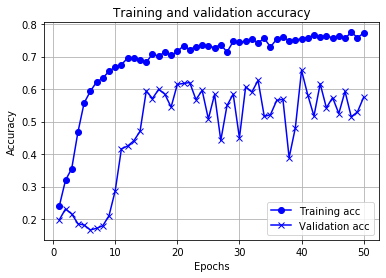


Test accurancy:
873/873 [==============================] - 1s 605us/step
 53.26460481441034 %

Normalized confusion matrix
[[0.18 0.   0.02 0.04 0.01 0.37 0.   0.38 0.   0.  ]
 [0.   0.78 0.   0.   0.03 0.   0.19 0.   0.   0.  ]
 [0.04 0.   0.36 0.26 0.01 0.08 0.   0.   0.18 0.07]
 [0.01 0.   0.   0.77 0.   0.12 0.07 0.   0.03 0.  ]
 [0.03 0.02 0.   0.   0.5  0.13 0.02 0.3  0.   0.  ]
 [0.   0.   0.01 0.   0.03 0.67 0.   0.   0.29 0.  ]
 [0.   0.   0.   0.17 0.03 0.   0.77 0.03 0.   0.  ]
 [0.   0.   0.   0.   0.4  0.28 0.   0.28 0.05 0.  ]
 [0.   0.   0.   0.   0.   0.13 0.   0.   0.87 0.  ]
 [0.12 0.07 0.   0.   0.1  0.07 0.   0.04 0.03 0.57]]
Test accuracy = 53.264604810996566


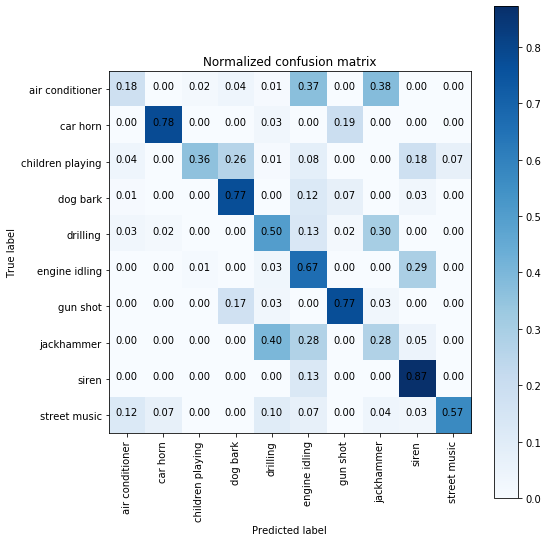

In [39]:
filename_model = 'CNN14'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), padding='same'))
model.add(Conv2D(32, (3,3), kernel_regularizer=l2(0.1), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

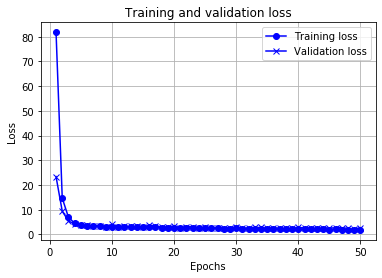

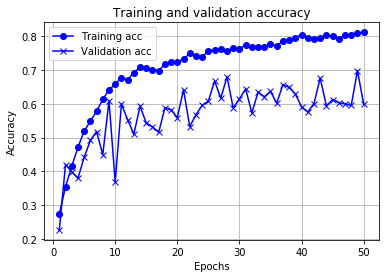


Test accurancy:
873/873 [==============================] - 1s 664us/step
 64.71935854403287 %

Normalized confusion matrix
[[0.26 0.04 0.03 0.21 0.26 0.   0.   0.   0.   0.2 ]
 [0.   0.81 0.03 0.   0.   0.   0.17 0.   0.   0.  ]
 [0.   0.   0.7  0.15 0.   0.   0.   0.   0.   0.15]
 [0.   0.   0.02 0.96 0.   0.   0.   0.   0.02 0.  ]
 [0.   0.01 0.01 0.11 0.6  0.   0.   0.19 0.   0.08]
 [0.   0.   0.01 0.09 0.26 0.64 0.   0.   0.   0.  ]
 [0.   0.   0.   0.51 0.   0.   0.49 0.   0.   0.  ]
 [0.   0.01 0.   0.01 0.5  0.05 0.   0.43 0.   0.  ]
 [0.   0.   0.14 0.13 0.   0.   0.   0.   0.73 0.  ]
 [0.02 0.   0.02 0.   0.   0.   0.   0.03 0.02 0.91]]
Test accuracy = 64.71935853379152


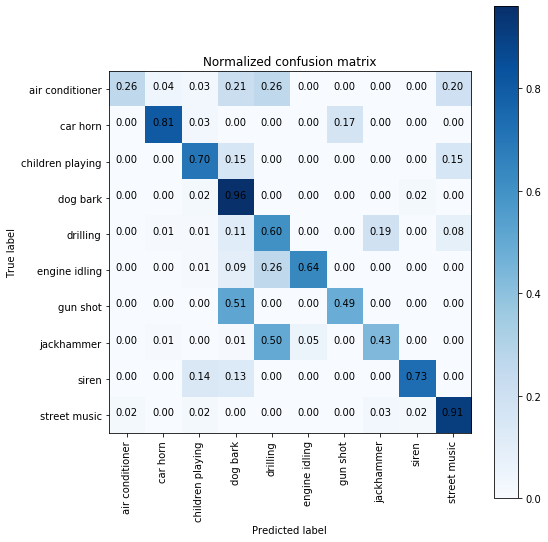

In [40]:
filename_model = 'CNN15'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), use_bias=True, input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), use_bias=True, padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), use_bias=True, padding='same'))
model.add(Conv2D(32, (3,3), use_bias=True, padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 32)        9248      
__________

Epoch 41/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.9330 - acc: 0.8035 - val_loss: 2.4385 - val_acc: 0.6404
Epoch 42/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.8492 - acc: 0.8151 - val_loss: 2.3997 - val_acc: 0.6376
Epoch 43/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.7931 - acc: 0.8144 - val_loss: 2.3804 - val_acc: 0.5990
Epoch 44/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.8291 - acc: 0.8197 - val_loss: 2.1856 - val_acc: 0.6409
Epoch 45/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.7976 - acc: 0.8136 - val_loss: 2.8196 - val_acc: 0.6023
Epoch 46/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.8452 - acc: 0.8184 - val_loss: 2.6285 - val_acc: 0.5681
Epoch 47/50
6046/6046 [==============================] - 12s 2ms/step - loss: 1.8188 - acc: 0.8169 - val_loss: 2.4005 - val_acc: 0.6332
Epoch 48/50
6046/6046 [=========================

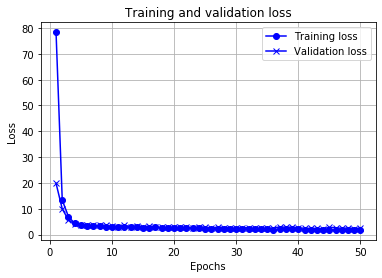

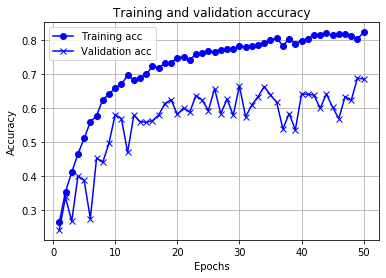


Test accurancy:
873/873 [==============================] - 1s 1ms/step
 67.01030928176431 %

Normalized confusion matrix
[[0.24 0.01 0.11 0.04 0.04 0.17 0.01 0.14 0.   0.24]
 [0.   0.86 0.   0.   0.03 0.   0.11 0.   0.   0.  ]
 [0.02 0.   0.73 0.07 0.   0.01 0.   0.   0.01 0.16]
 [0.01 0.   0.08 0.84 0.03 0.02 0.   0.   0.02 0.  ]
 [0.06 0.   0.01 0.01 0.75 0.   0.   0.15 0.02 0.  ]
 [0.02 0.   0.02 0.   0.32 0.64 0.   0.   0.   0.  ]
 [0.   0.   0.   0.23 0.09 0.   0.63 0.06 0.   0.  ]
 [0.   0.   0.   0.   0.47 0.02 0.   0.51 0.01 0.  ]
 [0.   0.   0.   0.   0.   0.1  0.   0.   0.9  0.  ]
 [0.03 0.   0.01 0.   0.14 0.   0.   0.03 0.02 0.77]]
Test accuracy = 67.0103092783505


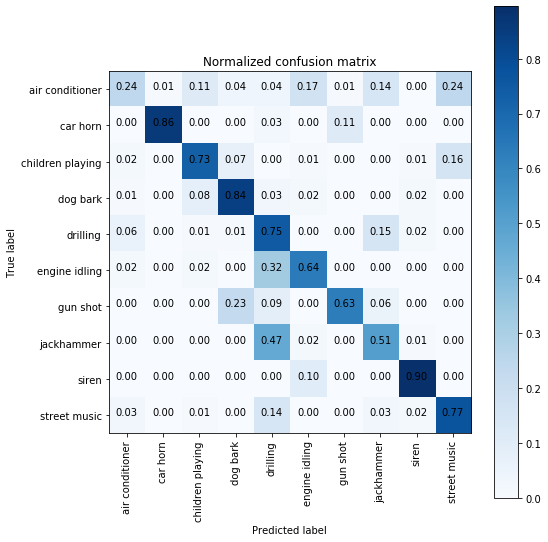

In [41]:
filename_model = 'CNN16'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(64, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(32, (3,3), padding='same'))
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

Epoch 41/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.3845 - acc: 0.7833 - val_loss: 2.8371 - val_acc: 0.6315
Epoch 42/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.3750 - acc: 0.7784 - val_loss: 2.8102 - val_acc: 0.5946
Epoch 43/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.2850 - acc: 0.7923 - val_loss: 2.9327 - val_acc: 0.6156
Epoch 44/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.2240 - acc: 0.7903 - val_loss: 2.7243 - val_acc: 0.6426
Epoch 45/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.1011 - acc: 0.8010 - val_loss: 2.7502 - val_acc: 0.6205
Epoch 46/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.1485 - acc: 0.8025 - val_loss: 2.5951 - val_acc: 0.6211
Epoch 47/50
6046/6046 [==============================] - 11s 2ms/step - loss: 2.1363 - acc: 0.8090 - val_loss: 2.6519 - val_acc: 0.6293
Epoch 48/50
6046/6046 [=========================

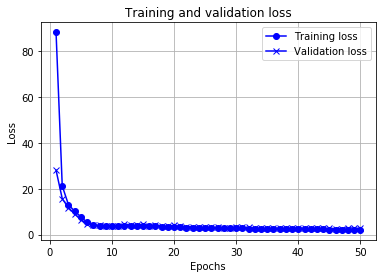

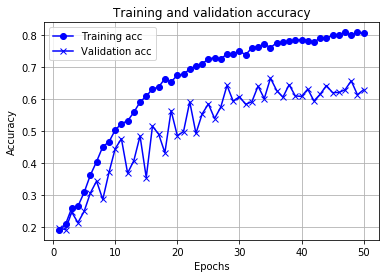


Test accurancy:
873/873 [==============================] - 1s 940us/step
 65.63573885209782 %

Normalized confusion matrix
[[0.4  0.   0.04 0.18 0.02 0.06 0.01 0.04 0.   0.25]
 [0.   0.58 0.   0.11 0.03 0.   0.28 0.   0.   0.  ]
 [0.04 0.   0.76 0.09 0.   0.   0.   0.   0.   0.11]
 [0.02 0.   0.08 0.83 0.   0.01 0.06 0.   0.   0.  ]
 [0.15 0.   0.03 0.28 0.34 0.   0.05 0.14 0.   0.01]
 [0.   0.   0.01 0.02 0.3  0.66 0.   0.01 0.   0.  ]
 [0.   0.   0.   0.03 0.   0.   0.97 0.   0.   0.  ]
 [0.02 0.   0.   0.   0.32 0.03 0.   0.64 0.   0.  ]
 [0.03 0.   0.13 0.07 0.   0.02 0.   0.   0.74 0.  ]
 [0.05 0.   0.04 0.01 0.03 0.   0.   0.03 0.03 0.81]]
Test accuracy = 65.63573883161511


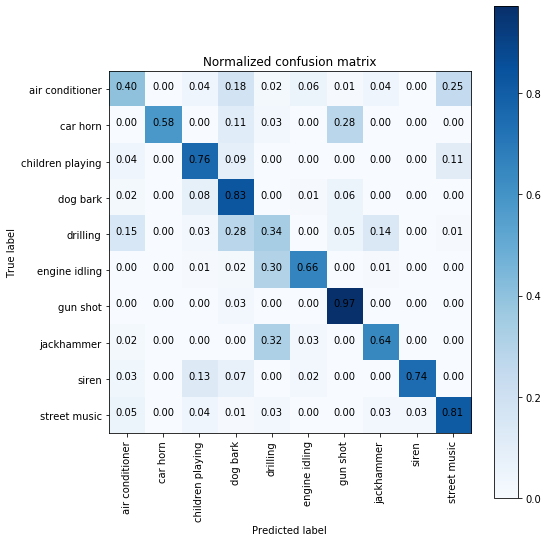

In [42]:
filename_model = 'CNN17'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

6046/6046 [==============================] - 10s 2ms/step - loss: 0.8927 - acc: 0.9016 - val_loss: 1.7939 - val_acc: 0.6586
Epoch 37/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.8768 - acc: 0.9135 - val_loss: 1.9839 - val_acc: 0.6630
Epoch 38/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.8620 - acc: 0.9099 - val_loss: 1.9433 - val_acc: 0.6834
Epoch 39/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.8703 - acc: 0.9173 - val_loss: 2.3469 - val_acc: 0.6349
Epoch 40/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.9303 - acc: 0.9109 - val_loss: 2.1914 - val_acc: 0.6133
Epoch 41/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.8563 - acc: 0.9143 - val_loss: 1.9108 - val_acc: 0.6652
Epoch 42/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.8561 - acc: 0.9100 - val_loss: 2.2959 - val_acc: 0.5665
Epoch 43/50
6046/6046 [==============================] - 10s

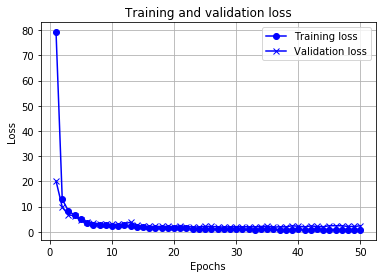

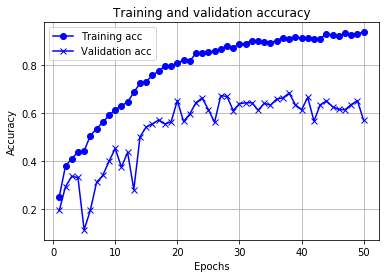


Test accurancy:
873/873 [==============================] - 1s 872us/step
 56.7010309380764 %

Normalized confusion matrix
[[0.27 0.   0.26 0.01 0.01 0.24 0.01 0.01 0.   0.19]
 [0.   0.89 0.   0.   0.   0.   0.11 0.   0.   0.  ]
 [0.01 0.   0.79 0.   0.   0.   0.   0.   0.   0.2 ]
 [0.   0.02 0.17 0.74 0.01 0.01 0.   0.   0.   0.05]
 [0.08 0.04 0.03 0.06 0.27 0.   0.02 0.07 0.02 0.41]
 [0.18 0.   0.02 0.01 0.   0.32 0.   0.   0.07 0.4 ]
 [0.   0.   0.06 0.03 0.   0.   0.91 0.   0.   0.  ]
 [0.07 0.01 0.01 0.   0.5  0.07 0.   0.3  0.02 0.03]
 [0.01 0.01 0.16 0.   0.   0.   0.   0.   0.71 0.1 ]
 [0.   0.   0.01 0.   0.   0.   0.   0.03 0.   0.96]]
Test accuracy = 56.70103092783505


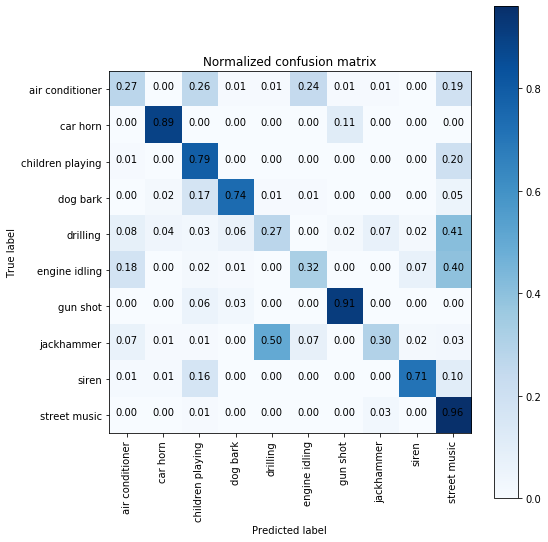

In [43]:
filename_model = 'CNN18'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

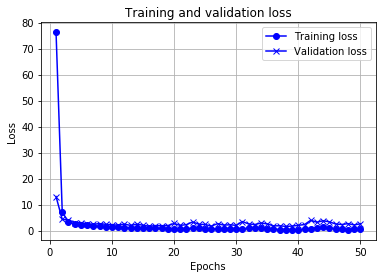

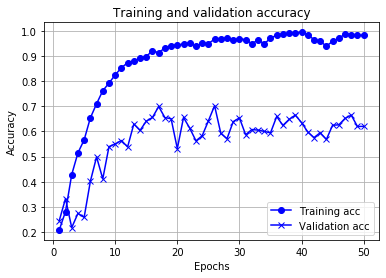


Test accurancy:
873/873 [==============================] - 1s 921us/step
 65.8648339094848 %

Normalized confusion matrix
[[0.31 0.   0.03 0.03 0.48 0.07 0.   0.07 0.01 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.02 0.02 0.7  0.01 0.02 0.01 0.   0.   0.01 0.21]
 [0.   0.01 0.14 0.77 0.05 0.01 0.01 0.   0.01 0.  ]
 [0.16 0.01 0.03 0.   0.72 0.   0.02 0.05 0.01 0.  ]
 [0.01 0.   0.01 0.   0.33 0.62 0.   0.   0.02 0.  ]
 [0.   0.   0.09 0.   0.03 0.   0.89 0.   0.   0.  ]
 [0.02 0.   0.01 0.   0.65 0.   0.01 0.32 0.   0.  ]
 [0.   0.   0.09 0.01 0.   0.   0.   0.   0.9  0.  ]
 [0.01 0.02 0.   0.   0.07 0.   0.   0.03 0.04 0.83]]
Test accuracy = 65.86483390607101


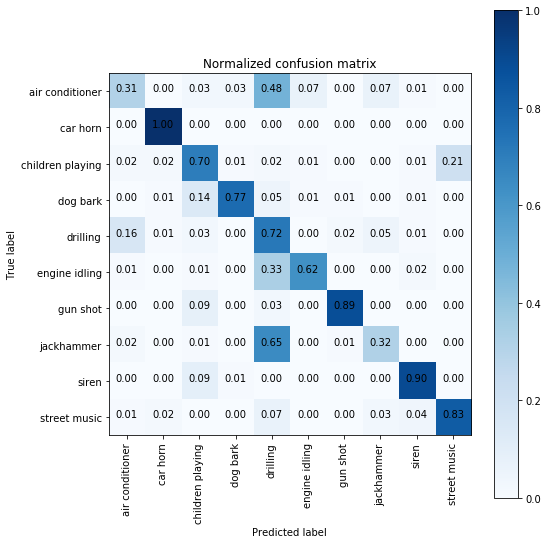

In [45]:
filename_model = 'CNN19'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(1024,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(1024, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

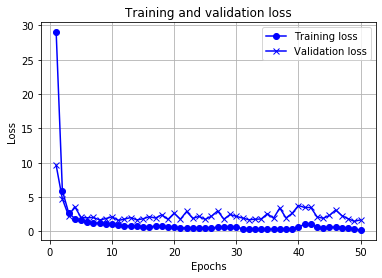

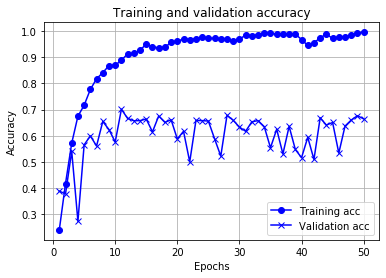


Test accurancy:
873/873 [==============================] - 1s 794us/step
 73.19587629207358 %

Normalized confusion matrix
[[0.29 0.   0.04 0.37 0.09 0.19 0.   0.02 0.   0.  ]
 [0.   0.89 0.11 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.03 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.04 0.91 0.   0.05 0.   0.   0.   0.  ]
 [0.04 0.   0.   0.02 0.77 0.06 0.01 0.04 0.01 0.05]
 [0.   0.   0.   0.1  0.14 0.68 0.   0.   0.04 0.04]
 [0.   0.   0.06 0.   0.03 0.   0.89 0.03 0.   0.  ]
 [0.03 0.   0.   0.   0.5  0.07 0.01 0.37 0.03 0.  ]
 [0.   0.   0.   0.01 0.   0.01 0.   0.   0.98 0.  ]
 [0.   0.   0.04 0.   0.03 0.   0.   0.04 0.   0.89]]
Test accuracy = 73.19587628865979


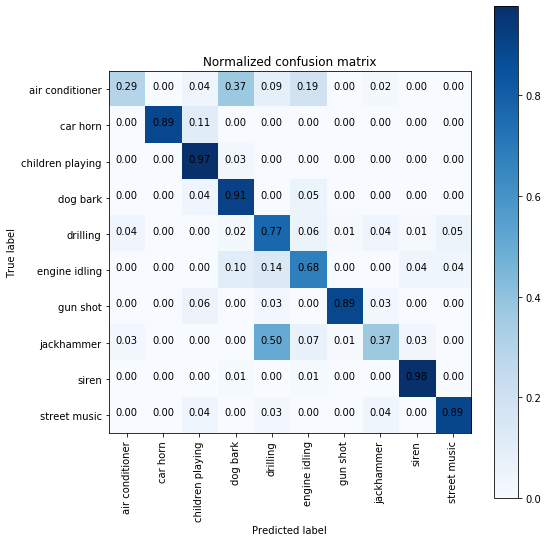

In [46]:
filename_model = 'CNN20'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(256,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

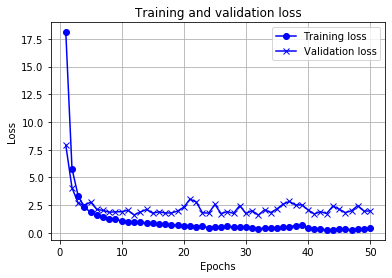

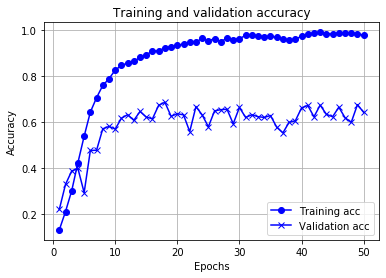


Test accurancy:
873/873 [==============================] - 1s 777us/step
 68.72852235725246 %

Normalized confusion matrix
[[0.27 0.08 0.14 0.05 0.   0.21 0.02 0.09 0.   0.14]
 [0.   0.89 0.   0.   0.   0.   0.11 0.   0.   0.  ]
 [0.   0.   0.94 0.01 0.   0.01 0.   0.   0.   0.04]
 [0.   0.   0.11 0.86 0.   0.01 0.   0.   0.01 0.01]
 [0.04 0.03 0.1  0.09 0.34 0.05 0.02 0.3  0.02 0.01]
 [0.01 0.   0.   0.31 0.02 0.66 0.   0.   0.   0.  ]
 [0.   0.   0.03 0.06 0.   0.   0.91 0.   0.   0.  ]
 [0.   0.   0.02 0.   0.38 0.   0.01 0.59 0.   0.  ]
 [0.01 0.   0.07 0.02 0.   0.   0.   0.   0.9  0.  ]
 [0.03 0.   0.06 0.01 0.   0.   0.   0.03 0.03 0.84]]
Test accuracy = 68.72852233676976


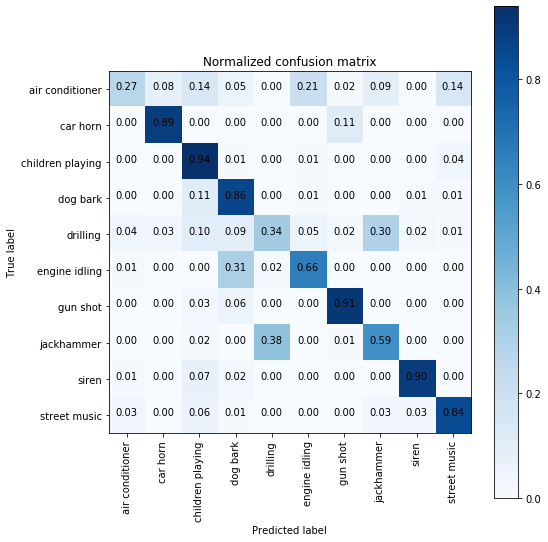

In [47]:
filename_model = 'CNN21'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(128,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(128, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

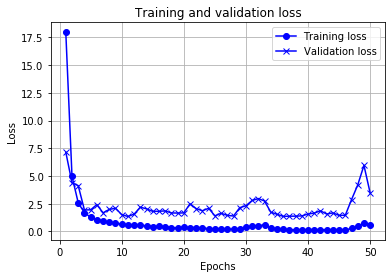

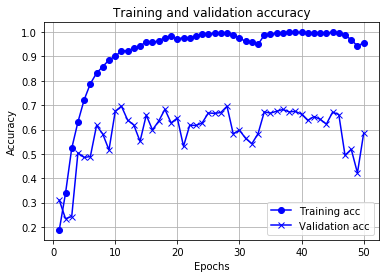


Test accurancy:
873/873 [==============================] - 1s 915us/step
 63.573883188822286 %

Normalized confusion matrix
[[0.22 0.08 0.02 0.21 0.12 0.29 0.   0.05 0.01 0.  ]
 [0.   0.89 0.   0.11 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.4  0.   0.07 0.   0.01 0.01 0.01]
 [0.   0.   0.   0.91 0.   0.06 0.   0.01 0.02 0.  ]
 [0.   0.03 0.02 0.04 0.68 0.   0.01 0.21 0.   0.01]
 [0.   0.   0.   0.   0.   0.66 0.   0.01 0.   0.33]
 [0.   0.   0.   0.17 0.03 0.03 0.74 0.03 0.   0.  ]
 [0.   0.   0.   0.01 0.49 0.   0.   0.5  0.   0.  ]
 [0.   0.   0.   0.01 0.   0.02 0.   0.01 0.95 0.  ]
 [0.03 0.   0.   0.12 0.15 0.01 0.   0.03 0.05 0.61]]
Test accuracy = 63.57388316151202


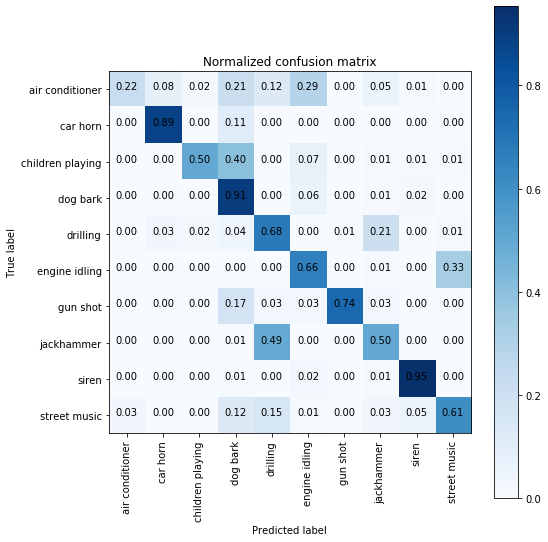

In [48]:
filename_model = 'CNN22'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(128,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(128, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

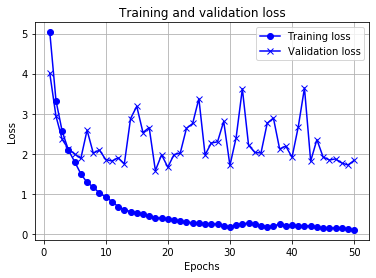

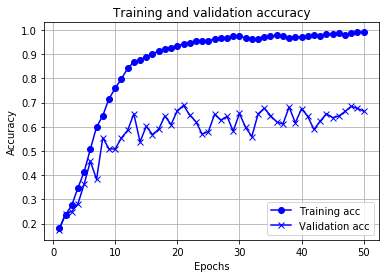


Test accurancy:
873/873 [==============================] - 1s 767us/step
 69.3012600433922 %

Normalized confusion matrix
[[0.52 0.   0.   0.   0.01 0.44 0.02 0.01 0.   0.  ]
 [0.   0.97 0.   0.   0.   0.   0.03 0.   0.   0.  ]
 [0.02 0.   0.95 0.   0.   0.   0.   0.   0.   0.03]
 [0.01 0.01 0.15 0.77 0.01 0.02 0.01 0.01 0.01 0.  ]
 [0.25 0.   0.   0.03 0.49 0.03 0.02 0.08 0.01 0.09]
 [0.04 0.   0.   0.08 0.14 0.64 0.   0.   0.   0.1 ]
 [0.   0.   0.   0.   0.03 0.   0.97 0.   0.   0.  ]
 [0.08 0.   0.   0.   0.54 0.08 0.01 0.28 0.   0.  ]
 [0.   0.   0.06 0.02 0.   0.   0.   0.   0.92 0.  ]
 [0.04 0.   0.02 0.   0.   0.   0.   0.03 0.02 0.89]]
Test accuracy = 69.3012600229095


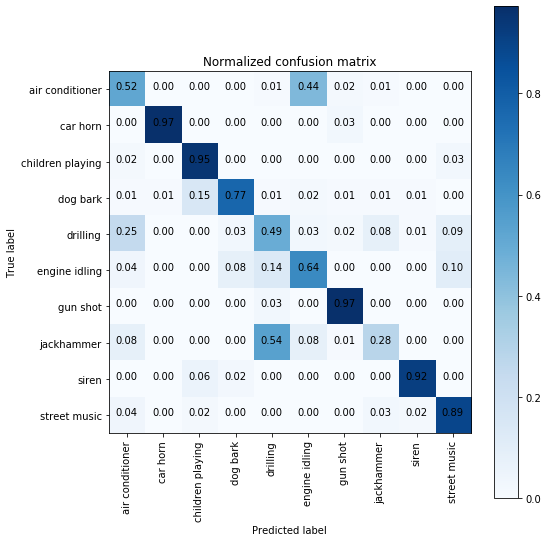

In [49]:
filename_model = 'CNN23'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(512, (3,3), padding='same'))
model.add(Conv2D(512, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(128,  kernel_regularizer=l2(0.01)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(128, kernel_regularizer=l2(0.01)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

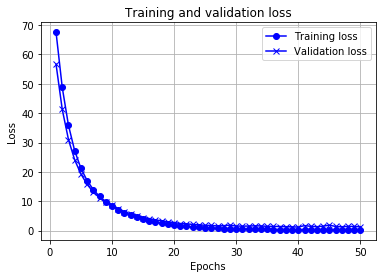

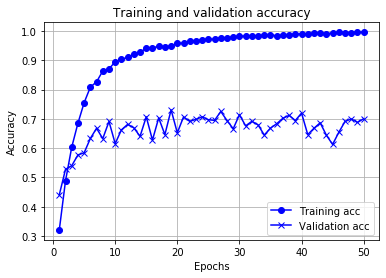


Test accurancy:
873/873 [==============================] - 1s 684us/step
 74.11225660013852 %

Normalized confusion matrix
[[0.38 0.03 0.08 0.04 0.01 0.33 0.01 0.12 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.96 0.   0.   0.   0.   0.   0.   0.04]
 [0.   0.   0.07 0.85 0.   0.05 0.   0.02 0.01 0.  ]
 [0.07 0.02 0.01 0.   0.64 0.05 0.03 0.13 0.   0.05]
 [0.07 0.   0.   0.   0.11 0.6  0.   0.   0.21 0.  ]
 [0.   0.   0.03 0.06 0.   0.   0.86 0.03 0.03 0.  ]
 [0.   0.   0.   0.   0.33 0.05 0.01 0.62 0.   0.  ]
 [0.   0.   0.09 0.01 0.   0.   0.   0.01 0.88 0.  ]
 [0.01 0.   0.02 0.   0.02 0.01 0.   0.03 0.01 0.9 ]]
Test accuracy = 74.1122565864834


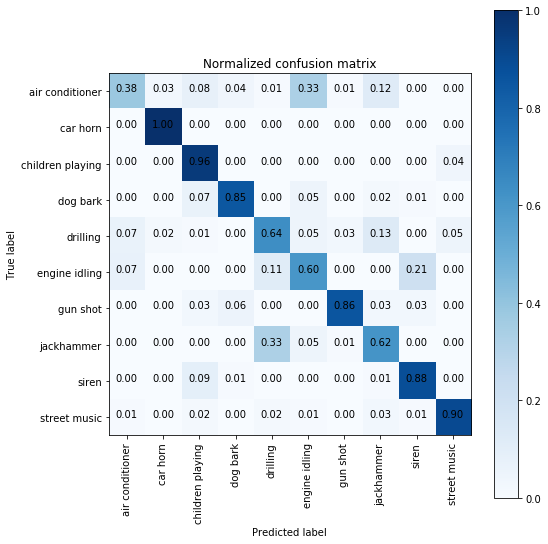

In [51]:
# Learning rate is decreased lr=0.0001
filename_model = 'CNN24'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()
model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  
model.add(Flatten())
model.add(Dense(256,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))
model.add(Dense(256, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))
model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.0001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

Epoch 31/50
6046/6046 [==============================] - 10s 2ms/step - loss: 31.1466 - acc: 0.7580 - val_loss: 30.9409 - val_acc: 0.6349
Epoch 32/50
6046/6046 [==============================] - 10s 2ms/step - loss: 30.3021 - acc: 0.7597 - val_loss: 30.0848 - val_acc: 0.6404
Epoch 33/50
6046/6046 [==============================] - 10s 2ms/step - loss: 29.4580 - acc: 0.7739 - val_loss: 29.2758 - val_acc: 0.6470
Epoch 34/50
6046/6046 [==============================] - 10s 2ms/step - loss: 28.6443 - acc: 0.7784 - val_loss: 28.5072 - val_acc: 0.6354
Epoch 35/50
6046/6046 [==============================] - 10s 2ms/step - loss: 27.8754 - acc: 0.7827 - val_loss: 27.7502 - val_acc: 0.6542
Epoch 36/50
6046/6046 [==============================] - 10s 2ms/step - loss: 27.1356 - acc: 0.7873 - val_loss: 27.0295 - val_acc: 0.6404
Epoch 37/50
6046/6046 [==============================] - 10s 2ms/step - loss: 26.4008 - acc: 0.7957 - val_loss: 26.3258 - val_acc: 0.6569
Epoch 38/50
6046/6046 [===========

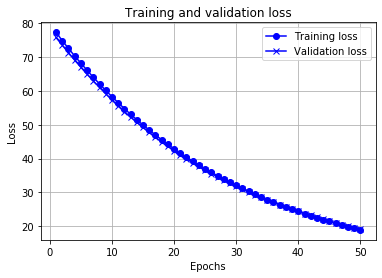

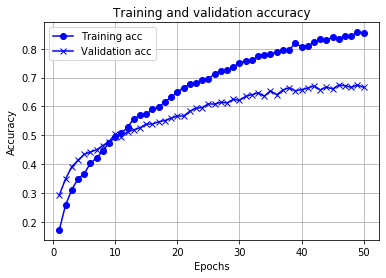


Test accurancy:
873/873 [==============================] - 1s 734us/step
 70.6758304901276 %

Normalized confusion matrix
[[0.44 0.   0.08 0.22 0.01 0.17 0.   0.05 0.02 0.01]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.95 0.02 0.   0.   0.   0.   0.01 0.02]
 [0.   0.01 0.08 0.86 0.   0.04 0.   0.   0.01 0.  ]
 [0.16 0.01 0.08 0.   0.52 0.03 0.06 0.13 0.   0.01]
 [0.03 0.   0.   0.22 0.1  0.65 0.   0.   0.   0.  ]
 [0.   0.   0.   0.17 0.03 0.   0.8  0.   0.   0.  ]
 [0.02 0.   0.01 0.   0.29 0.07 0.   0.58 0.03 0.  ]
 [0.01 0.   0.2  0.02 0.   0.   0.   0.   0.77 0.  ]
 [0.07 0.   0.04 0.   0.02 0.   0.   0.03 0.06 0.78]]
Test accuracy = 70.67583046964491


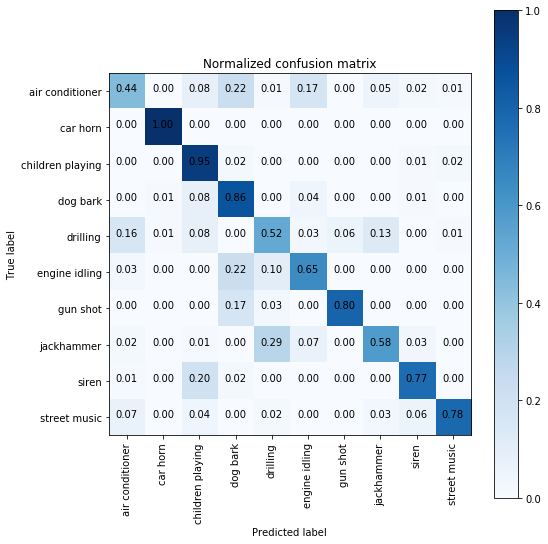

In [52]:
# Learning rate is decreased lr=0.00001
filename_model = 'CNN25'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(256,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 100, 125, 0.00001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 124, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 63, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 62, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 63, 62, 64)        36928     
__________

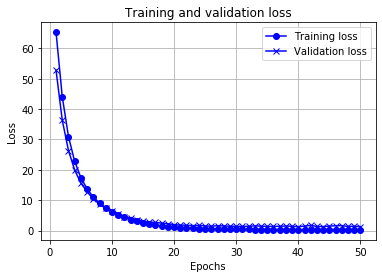

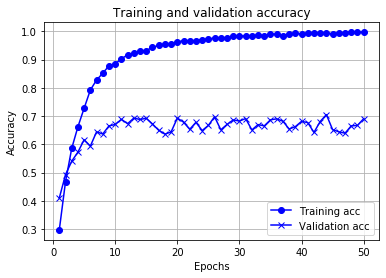


Test accurancy:
873/873 [==============================] - 1s 711us/step
 67.58304698497297 %

Normalized confusion matrix
[[0.28 0.02 0.09 0.08 0.01 0.37 0.   0.14 0.01 0.  ]
 [0.   0.89 0.   0.   0.   0.   0.11 0.   0.   0.  ]
 [0.   0.   0.99 0.01 0.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.05 0.87 0.   0.02 0.01 0.   0.04 0.  ]
 [0.14 0.02 0.02 0.12 0.48 0.05 0.03 0.11 0.01 0.02]
 [0.   0.   0.   0.   0.29 0.68 0.   0.   0.02 0.01]
 [0.   0.   0.   0.03 0.   0.   0.94 0.03 0.   0.  ]
 [0.   0.   0.   0.   0.41 0.19 0.01 0.38 0.01 0.  ]
 [0.   0.   0.14 0.02 0.   0.   0.   0.   0.84 0.  ]
 [0.02 0.   0.04 0.02 0.02 0.01 0.   0.03 0.06 0.8 ]]
Test accuracy = 67.58304696449026


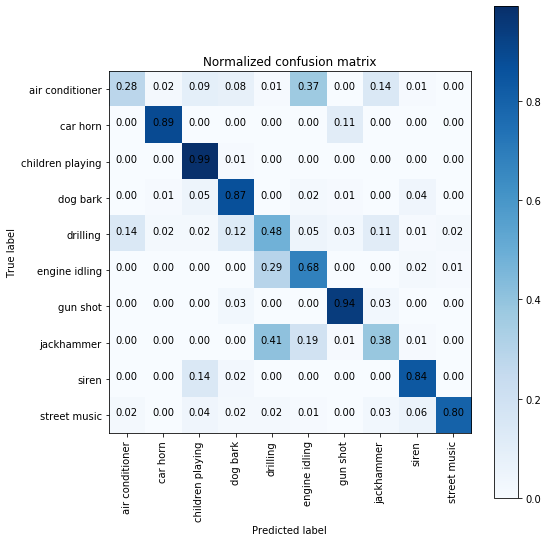

In [53]:
# Learning rate is decreased lr=0.0001 + batch size 125-> 100
filename_model = 'CNN26'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (3,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (3,3), padding='same'))
model.add(Conv2D(64, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Conv2D(128, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (3,3), padding='same'))
model.add(Conv2D(256, (3,3), padding='same'))
model.add(MaxPooling2D((2,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(256,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 100, 0.0001)
model.save('./model/'+filename_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 124, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 124, 32)      3104      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 62, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 62, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 62, 64)        12352     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 62, 64)        24640     
__________

6046/6046 [==============================] - 10s 2ms/step - loss: 0.6782 - acc: 0.9643 - val_loss: 1.4404 - val_acc: 0.6950
Epoch 32/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.6418 - acc: 0.9610 - val_loss: 1.4194 - val_acc: 0.6768ss: 0.
Epoch 33/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.5996 - acc: 0.9653 - val_loss: 1.4255 - val_acc: 0.6669
Epoch 34/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.5806 - acc: 0.9641 - val_loss: 1.4398 - val_acc: 0.6834
Epoch 35/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.5400 - acc: 0.9720 - val_loss: 1.3689 - val_acc: 0.6657
Epoch 36/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.5294 - acc: 0.9676 - val_loss: 1.3407 - val_acc: 0.6839
Epoch 37/50
6046/6046 [==============================] - 10s 2ms/step - loss: 0.4962 - acc: 0.9747 - val_loss: 1.3338 - val_acc: 0.6608
Epoch 38/50
6046/6046 [==============================]

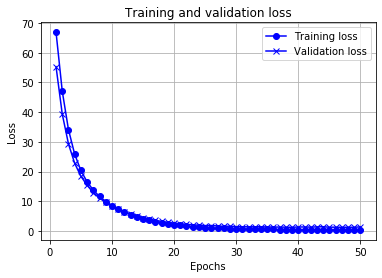

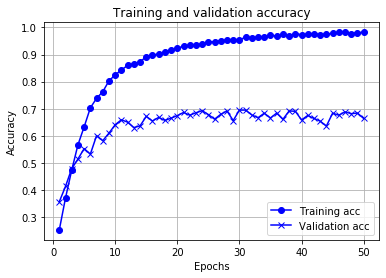


Test accurancy:
873/873 [==============================] - 1s 881us/step
 68.15578467111271 %

Normalized confusion matrix
[[0.36 0.01 0.15 0.04 0.25 0.   0.   0.12 0.   0.07]
 [0.   0.89 0.   0.   0.   0.   0.11 0.   0.   0.  ]
 [0.   0.   0.86 0.03 0.03 0.   0.   0.   0.   0.08]
 [0.01 0.   0.08 0.85 0.03 0.   0.02 0.   0.   0.01]
 [0.03 0.01 0.   0.02 0.84 0.01 0.02 0.03 0.   0.04]
 [0.02 0.   0.   0.   0.24 0.64 0.   0.   0.   0.1 ]
 [0.   0.   0.   0.11 0.11 0.   0.77 0.   0.   0.  ]
 [0.07 0.   0.   0.   0.6  0.05 0.   0.23 0.04 0.  ]
 [0.03 0.   0.08 0.   0.02 0.   0.   0.   0.86 0.  ]
 [0.03 0.   0.03 0.   0.04 0.   0.   0.03 0.05 0.82]]
Test accuracy = 68.15578465063001


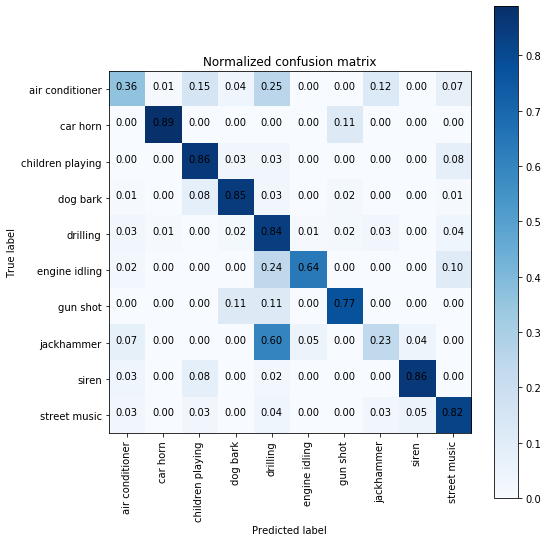

In [54]:
# Learning rate is decreased lr=0.0001
filename_model = 'CNN27'

num_rows = X_train_stand_score.shape[1]
num_columns = X_train_stand_score.shape[2]
num_channels = 1
num_labels = 10


keras.backend.clear_session()

# padding = 'same' to keep the orginal image size

model = models.Sequential()

model.add(Conv2D(32, (1,3), input_shape = (num_rows,num_columns,num_channels))) 
model.add(Conv2D(32, (1,3), padding='same'))
model.add(MaxPooling2D((1,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu')) 

model.add(Conv2D(64, (6,1), padding='same'))
model.add(Conv2D(64, (6,1), padding='same'))
model.add(MaxPooling2D((4,1), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))       

model.add(Conv2D(128, (1,3), padding='same'))
model.add(Conv2D(128, (1,3), padding='same'))
model.add(MaxPooling2D((1,2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Conv2D(256, (6,1), padding='same'))
model.add(Conv2D(256, (6,1), padding='same'))
model.add(MaxPooling2D((4,1), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))  

model.add(Flatten())
          
model.add(Dense(256,  kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(256, kernel_regularizer=l2(0.1)))
model.add(Activation('relu')) 
model.add(Dropout(0.5))

model.add(Dense(10,activation ='softmax'))


model.summary()


network(model, 50, 125, 0.0001)
model.save('./model/'+filename_model)

### [EOF]